# Gaussian obstacles (with simply one obstacle)

We are going to implement a code for simple path planning problem

$J(v,\theta):=\int_0^Tc(X_t)dt+g(X_T)$


State Process $dX_{t}=v_t\left(\begin{matrix}\cos\theta_t\\\sin\theta_t\end{matrix}\right)dt$

$\inf_{v_t,\theta_t}J(v,\theta)$

$c(x)=c_0(x)1\!\!1_{\{x\in R\}}$ and $g(x) = g_0(x)1\!\!1_{\{x\not\in E\}}$

For example, if the target point is $\hat{x}$, then $E=B_\epsilon(\hat{x})$ with $g_0(x)=|x-\hat{x}|^2$

The indicator function can be approximated by smooth functions: $1_{\{x\not\in E\}}\approx\exp(-\epsilon_0/(\epsilon_1+|x-\hat{x}|^2))$


Similarly, $c_0$ in the running cost can be chosen to be a constant.  Also, we can write $c(x)=g(x)1\!\!1_{\{x\not\in R\}}+c_0(x)1\!\!1_{\{x\in R\}}$ to always remind the vehicle to go toward the target. However, one may wants to choose $c_0$ large enough to avoid overriding the obstacle. 

Indicator in obstacle can also be approximated by smooth functions. If $R=B_\epsilon(\tilde{x})$, then $1\!\!1_{\{x\in R\}}\approx 1\!\!1_{\{x\in R\}}\exp(-\theta_0|x-\tilde{x}|^2)$ 

It is also possible to write $c(x)=g_0(x)1\!\!1_{\{x\not\in R\}}+c_0(x)1\!\!1_{\{x\in R\}}$ to avoid over riding the obstacle by the target. Then, 

$c(x)\approx |x-\hat{x}|^2\exp(-\epsilon_0/(\epsilon_1+|x-\hat{x}|^2))1\!\!1_{\{x\not\in R\}}+c_0(x)\big(\exp(-\theta_0|x-\tilde{x}|^2)\big)1\!\!1_{\{x\in R\}}$


Gaussian obstacle helps the path to get closed to the obstacle, but it imposes a slight bent in the path, where it is supposed to be straight.

In [1]:
import numpy as np
import time
from scipy import misc
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import matplotlib.patches as patches
font = font_manager.FontProperties(style='normal', size=20)
plt.rc('text', usetex=True)
plt.rc('text.latex', preamble=r'\usepackage{amsmath}')
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.set_default_dtype(torch.float64)
import random
import math
import pandas as pd
from scipy.optimize import fsolve
# from scipy.integrate import solve_ivp # type: ignore
import scipy.integrate as integrate

import json

from IPython.display import display, Math, Markdown
import seaborn as sns
sns.set(font_scale = 2)

import pandas as pd
import datetime
import os
timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
timestamp
version = '_4'
import math
pi = math.pi

# Obstacle profile

In [2]:
def grad(f):
    def result(x):
       # make leaf variables out of the inputs
       x_ = x.detach().requires_grad_(True) 
       f(x_).backward()
       return x_.grad
    return result

In [3]:
def base_line(x):
    loss_= 1+torch.pow(x-1.,2)+torch.exp(-1e-3/(1e-9+torch.pow(x-1.,2)))
    return  loss_
    
def obstacles(x):
    force = 20.
    sigma2inv1 = torch.tensor([100.*100./2.])
    sigma2inv2 = torch.tensor([50.*50./2.])
    sigma2inv3 = torch.tensor([100.*100./2.])
    mag1 = base_line(torch.tensor([0.1]))
    mag2 = base_line(torch.tensor([0.5]))
    mag3 = base_line(torch.tensor([0.9]))
    a1  = (torch.pow(x-0.1,2)<=4/sigma2inv1).float() - torch.nn.ReLU()(x) + torch.nn.ReLU()(x)
    a2  = (torch.pow(x-0.5,2)<=4/sigma2inv2).float() #- torch.nn.ReLU()(x) + torch.nn.ReLU()(x)
    a3  = (torch.pow(x-0.9,2)<=4/sigma2inv3).float()
    o1 = (mag1+force*torch.exp(-sigma2inv1*torch.pow(x-0.1,2)))*a1
    o2 = (mag2+force*torch.exp(-sigma2inv2*torch.pow(x-0.5,2)))*a2
    o3 = (mag3+force*torch.exp(-sigma2inv3*torch.pow(x-0.9,2)))*a3
    o = o1+o2+o3
    return  o

def g(x):
    return base_line(x)+obstacles(x)

def vanish(x):
    sigma2inv1 = torch.tensor([100.*100./2.])
    sigma2inv2 = torch.tensor([50.*50./2.])
    sigma2inv3 = torch.tensor([100.*100./2.])
    a1  = (torch.pow(x-0.1,2)>4/sigma2inv1).float() - torch.nn.ReLU()(x) + torch.nn.ReLU()(x)
    a2  = (torch.pow(x-0.5,2)>4/sigma2inv2).float() #- torch.nn.ReLU()(x) + torch.nn.ReLU()(x)
    a3  = (torch.pow(x-0.9,2)>4/sigma2inv3).float()
    return a1*a2*a3
def counter(x):
    sigma2inv1 = torch.tensor([100.*100./2.])
    sigma2inv2 = torch.tensor([50.*50./2.])
    sigma2inv3 = torch.tensor([100.*100./2.])
    a1  = (torch.pow(x-0.1,2)<=4/sigma2inv1).float() - torch.nn.ReLU()(x) + torch.nn.ReLU()(x)
    a2  = (torch.pow(x-0.5,2)<=4/sigma2inv2).float() #- torch.nn.ReLU()(x) + torch.nn.ReLU()(x)
    a3  = (torch.pow(x-0.9,2)<=4/sigma2inv3).float()
    return a1+a2+a3

def g_vanish(x):
    return vanish(x)*base_line(x)+obstacles(x)

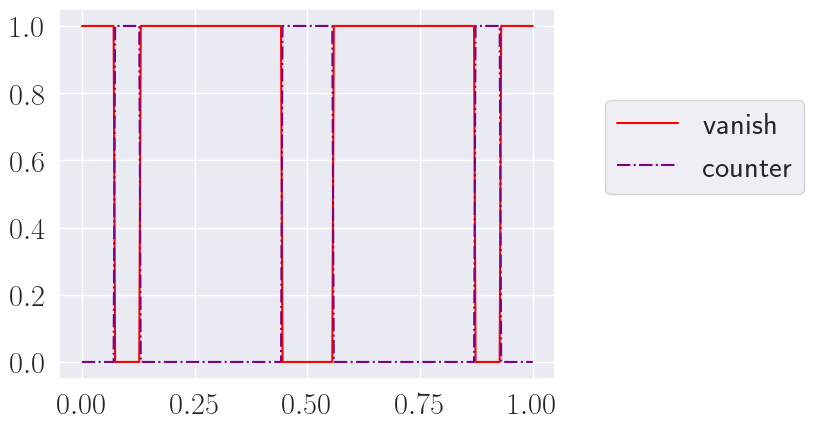

In [4]:
x = torch.linspace(0,1,300)
y3 = vanish(x)
y4 = counter(x)
plt.plot(x,y3,label='vanish', linestyle='-', color='red'); 
plt.plot(x,y4,label='counter', linestyle='-.', color='purple');
plt.legend(loc=[1.1,0.5]);

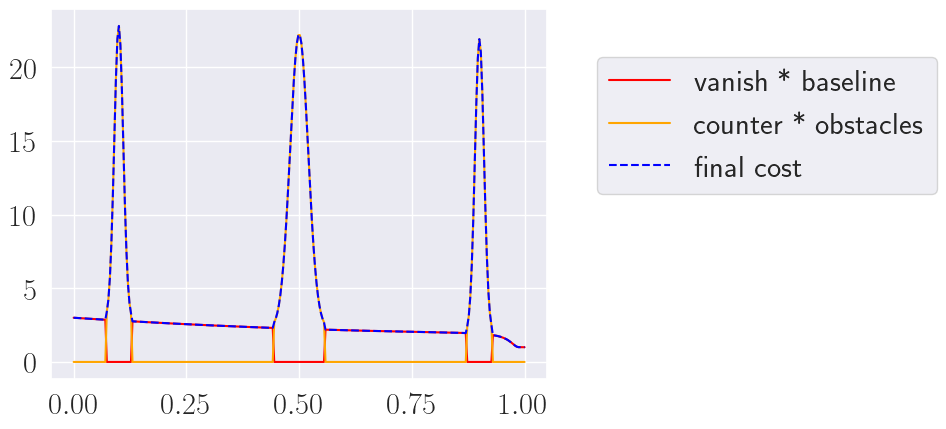

In [5]:
x = torch.linspace(0,1,300)
y5 = vanish(x)*base_line(x)
y6 = obstacles(x)
plt.plot(x,y5,label='vanish * baseline', linestyle='-', color='red'); 
plt.plot(x,y6,label='counter * obstacles', linestyle='-', color='orange');
plt.plot(x,y5+y6,label='final cost', linestyle='--', color='blue'); 


# plt.plot(x,z,label='baseline running + obstacle cost', linestyle='-', color='green');
# plt.plot(x,obstacles(x)+base_line(x),label='baseline running + obstacle cost');
# plt.plot(x,g_vanish(x),label='baseline running * vanish + obstacle cost * counter');
plt.legend(loc=[1.1,0.5]);

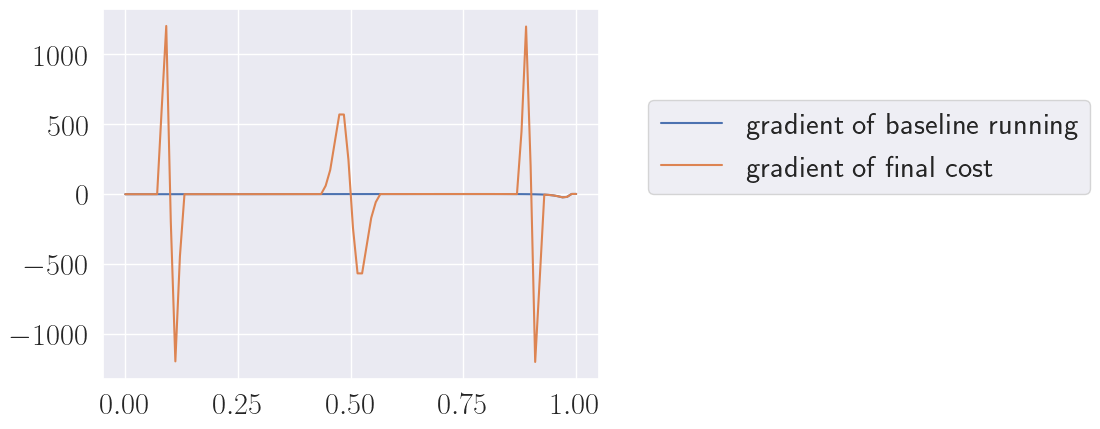

In [6]:
x = torch.linspace(0.,1.,100)
dy = torch.zeros(100)
for i,v in enumerate(x):
   dy[i] = grad(base_line)(v) 
dz = torch.zeros(100)
for i,v in enumerate(x):
   dz[i] = grad(g_vanish)(v) 
   
plt.plot(x,dy,label='gradient of baseline running');   
plt.plot(x,dz,label='gradient of final cost');
plt.legend(loc=[1.1,0.5]);
# print(grad(f)(torch.tensor(0.1)))

# PGM

## Problem parameters

In [7]:
opp_params = {
    'T':1.4,
    'v':1.,
    'target':[1.,1.],
    'obstacle':[[0.25,0.5],[0.75,0.75]],
    'running_cost':1.,
    'missing_target':1.,
    'tolerance':1e-2
    }

## PGM parameters

In [8]:

model_params = {
    'num_samples':300,
    'num_time_steps':15,
    'num_neurons_p':50,
    'num_neurons_v':10,
    'lr' : 1e-2,
    'num_epochs' : 2000,
    'xmin' : -.1,
    'xmax' : 1.,
    'ymin' : -.1,
    'ymax' : 1.,
    }

## PGM class

In [9]:
class pgm(object):
    def __init__(self, model_params, opp_params, **kwargs):
        self.value_eval = kwargs.get('value_eval', True)
        self.num_samples = model_params['num_samples']
        self.num_time_steps = model_params['num_time_steps']
        self.num_neurons_p = model_params['num_neurons_p']
        self.num_neurons_v = model_params['num_neurons_v']
        self.lr = model_params['lr']
        self.num_epochs = model_params['num_epochs']
        self.xmin = model_params['xmin']
        self.xmax = model_params['xmax']
        self.ymin = model_params['ymin']
        self.ymax = model_params['ymax']
        self.Num_steps = self.num_time_steps
        self.T = opp_params['T']
        self.delta = torch.tensor(self.T/self.num_time_steps)
        self.tol = opp_params['tolerance']
        self.missing_target = opp_params['missing_target']
        self.position_cost = opp_params['running_cost']
        self.v = opp_params['v']
        self.runc = opp_params['running_cost']
        # self.obstacle = opp_params['obstacle']
        self.tol = opp_params['tolerance']
        self.missing_target = opp_params['missing_target']
        self.running_cost = opp_params['running_cost']
        # obstacle size parameters
        self.sigma2inv1 = torch.tensor([100.*100./2.])
        self.sigma2inv2 = torch.tensor([20.*20./2.])
        self.sigma2inv3 = torch.tensor([100.*100./2.])


        self.model= torch.nn.Sequential(
            torch.nn.Linear(3, self.num_neurons_p),
            torch.nn.ReLU(),
            torch.nn.Linear(self.num_neurons_p, self.num_neurons_p),
            torch.nn.ReLU(),
            torch.nn.Linear(self.num_neurons_p,2),
            torch.nn.Sigmoid()
        )
        self.value= torch.nn.Sequential(
            torch.nn.Linear(3, self.num_neurons_v),
            torch.nn.Tanh(),
            torch.nn.Linear(self.num_neurons_v, self.num_neurons_v),
            torch.nn.Tanh(),
            torch.nn.Linear(self.num_neurons_v,1)
        )
        
        
    def gen_data(self):
        self.t=torch.zeros([self.num_samples,1])
        self.X0=torch.FloatTensor(self.num_samples,1).uniform_(self.xmin,self.xmax) 
        self.Y0=torch.FloatTensor(self.num_samples,1).uniform_(self.ymin,self.ymax)
        self.data=torch.stack([self.t,self.X0,self.Y0], dim=1).squeeze(-1)


    
    def update(self,x3,psi,i):
        t=x3[:,0]+self.delta
        target_ind = (torch.pow(x3[:,1]-1.,2)+torch.pow(x3[:,2]-1.,2)>0.001).float() - torch.nn.ReLU()(x3[:,1]) + torch.nn.ReLU()(x3[:,1])
        velocity = self.v*psi[:,0]
        angle = 2*pi*1.2*psi[:,1]
        x=x3[:,1]+velocity*torch.cos(angle)*self.delta*target_ind
        y=x3[:,2]+velocity*torch.sin(angle)*self.delta*target_ind
        up=torch.cat((t.unsqueeze(1),x.unsqueeze(1),y.unsqueeze(1)),dim=1)
        return up
    
    def base_line(self,tx):
        return 1+(torch.pow(tx[:,1]-1.,2))+torch.pow(tx[:,2]-1.,2)+torch.exp(-1e-3/(1e-9+(torch.pow(tx[:,1]-1.,2)+torch.pow(tx[:,2]-1.,2))))
    
    def obstacle(self,tx):
        force = 20.
        # a1  = (torch.pow(tx[:,1]-0.1,2)+torch.pow(tx[:,2]-0.1,2)<=4/self.sigma2inv1).float() - torch.nn.ReLU()(tx[:,1]) + torch.nn.ReLU()(tx[:,1])
        a2  = (torch.pow(tx[:,1]-0.5,2)+torch.pow(tx[:,2]-0.5,2)<=4/self.sigma2inv2).float() #- torch.nn.ReLU()(x) + torch.nn.ReLU()(x)
        # a3  = (torch.pow(tx[:,1]-0.9,2)+torch.pow(tx[:,2]-0.9,2)<=4/self.sigma2inv3).float()
        # mag1 = self.base_line(torch.tensor([[0.,0.1,0.1]]))
        mag2 = self.base_line(torch.tensor([[0.,0.5,0.5]]))
        # mag3 = self.base_line(torch.tensor([[0.,0.9,0.9]]))
        # mag = mag1+mag2+mag3
        # o1 = (mag1 + force*torch.exp(-self.sigma2inv1*(torch.pow(tx[:,1]-0.1,2)+torch.pow(tx[:,2]-0.1,2))))*a1
        o2 = (mag2 + force*torch.exp(-self.sigma2inv2*(torch.pow(tx[:,1]-0.5,2)+torch.pow(tx[:,2]-0.5,2))))*a2
        # o3 = (mag3 + force*torch.exp(-self.sigma2inv3*(torch.pow(tx[:,1]-0.9,2)+torch.pow(tx[:,2]-0.9,2))))*a3
        return o2 #o1+o2+o3

    # def counter(self,tx):
    #     a1  = (torch.pow(tx[:,1]-0.1,2)+torch.pow(tx[:,2]-0.1,2)<=4/self.sigma2inv1).float() - torch.nn.ReLU()(tx[:,1]) + torch.nn.ReLU()(tx[:,1])
    #     a2  = (torch.pow(tx[:,1]-0.5,2)+torch.pow(tx[:,2]-0.5,2)<=4/self.sigma2inv2).float() #- torch.nn.ReLU()(x) + torch.nn.ReLU()(x)
    #     a3  = (torch.pow(tx[:,1]-0.9,2)+torch.pow(tx[:,2]-0.9,2)<=4/self.sigma2inv3).float()
    #     return a1+a2+a3    

    def vanish(self,tx):
        # a1  = (torch.pow(tx[:,1]-0.1,2)+torch.pow(tx[:,2]-0.1,2)>4/self.sigma2inv1).float() - torch.nn.ReLU()(tx[:,1]) + torch.nn.ReLU()(tx[:,1])
        a2  = (torch.pow(tx[:,1]-0.5,2)+torch.pow(tx[:,2]-0.5,2)>4/self.sigma2inv2).float() #- torch.nn.ReLU()(x) + torch.nn.ReLU()(x)
        # a3  = (torch.pow(tx[:,1]-0.9,2)+torch.pow(tx[:,2]-0.9,2)>4/self.sigma2inv3).float()
        return a2 #a1*a2*a3

    def loss_func(self,tx,psi):
        loss_ = self.base_line(tx)*self.vanish(tx)+self.obstacle(tx)#*self.counter(tx)
        return loss_

    def loss_func_ter(self,tx):
        loss_ = (torch.pow(tx[:,1]-1.,2)+torch.pow(tx[:,2]-1.,2))+torch.exp(-1e-4/(1e-9+torch.pow(tx[:,1]-1.,2)+torch.pow(tx[:,2]-1.,2)))#(torch.pow(tx[:,1]-1.,2)+torch.pow(tx[:,2]-1.,2)>0.01).float() - torch.nn.ReLU()(tx[:,1]) + torch.nn.ReLU()(tx[:,1])
        return loss_

    def unit(self,x1,i,policy, **kwargs):
        x2 = kwargs.get('disc_policy', x1)
        psi=policy(x2).squeeze(1)
        loss=self.loss_func(x1,psi)
        # print(i,loss.requires_grad,x1.requires_grad,psi.requires_grad)
        upd=self.update(x1,psi,i)
        #print('unit print=',psi.shape,los.shape,upd.shape)
        return psi,loss,upd

    def loss_func_total(self,epoch):
        u = self.data
        path = torch.zeros(self.num_samples,self.num_time_steps+1,3)
        path_loss=torch.zeros(self.num_samples,self.num_time_steps+1)
        psi=torch.zeros(self.num_samples,self.num_time_steps,2)
        if (epoch==self.num_epochs-1):
            self.state_var=u.clone().detach()
            path[:,0,:] = u.clone().detach()
        for i in range(self.num_time_steps):
            psi_run,loss_run,u_run=self.unit(u,i,self.model)
            #print('los func=',psi_run.shape,loss_run.shape)
            path_loss[:,i]=loss_run*self.delta
            #print(loss)
            psi[:,i]=psi_run
            #print(psi)
            u=u_run
            if (epoch==self.num_epochs-1):
                self.state_var = torch.concat((self.state_var,u.clone().detach()), axis=0)      
                path[:,i+1,:] =   u.clone().detach()    
        path_loss[:,-1]=self.loss_func_ter(u)#/self.delta
        if (epoch==self.num_epochs-1):
            a = torch.flip(path_loss, dims = (1,))
            b = torch.cumsum(a, dim=1)
            c = torch.flip(b, dims = (1,))
            d = torch.transpose(c,0,1)
            self.path_cost = d.reshape((self.num_time_steps+1)*self.num_samples,1).clone().detach()
            p = torch.transpose(path,0,1)
            self.path = p.reshape((self.num_time_steps+1)*self.num_samples,3).clone().detach()
        loss_=torch.sum(path_loss,dim=1)
        # print(loss_.requires_grad)
        return loss_
    
    def train_it(self,**kwargs):
        M = kwargs.get('num_epochs', self.num_epochs)
        self.gen_data()
        start=time.time()
        cost_ar=[]
        optimizer = optim.Adam(self.model.parameters(), self.lr)
        E_ = -1e9
        E = 1e9
        m = 0
        while (np.abs((E-E_)/E_)>1e-12) and ( m <= M): #
            optimizer.zero_grad()
            cost = self.loss_func_total(m)
            loss = torch.mean(cost)
            loss.backward()
            optimizer.step()
            cost_ar.append(loss)
            E_ = E
            E = loss.clone().detach().numpy().item()
            m += 1
            if (m % 100==0):
                print("At epoch {} the mean cost is {}.".format(m,loss.detach()))
        #Run it one last time after training to save the path and cost
        optimizer.zero_grad()
        cost = self.loss_func_total(self.num_epochs-1)
        loss = torch.mean(cost)
        loss.backward()
        optimizer.step()
        cost_ar.append(loss)
        E_ = E
        E = loss.clone().detach().numpy().item()
            
        end=time.time()
        total_time=end-start
        print('Training time=',total_time)
        print("Last training epoch was {:d}".format(m+1))
        if self.value_eval:
            self.train_val_fnc()
    
    def policy(self,tx):
        return self.model(tx)
    
    def train_val_fnc(self,**kwargs):
        M = kwargs.get('num_epochs', self.num_epochs)
        K = kwargs.get('num_samples', self.num_samples)
        permuted_range = np.random.permutation((self.num_time_steps+1)*K)
        num_batches = int((K-1)/50) + 1
        epoch_cut = int(M/num_batches)
        tx = self.path[permuted_range,:]
        val = self.path_cost[permuted_range,:]
        optimizer_v = optim.Adam(self.value.parameters(), self.lr)
        start=time.time()
        E_ = -1e9
        E = 1e9
        m = 0
        i = -1
        while (np.abs((E-E_)/E_)>1e-16) and ( m <= M):
            i = int(m/epoch_cut)
        # for _ in range(M):
            r = range(i*50*(self.num_time_steps+1),min((i+1)*50*(self.num_time_steps+1),(self.num_time_steps+1)*K))
            loss_v = torch.nn.MSELoss()(self.value(tx[r,:]),val[r,:])
            optimizer_v.zero_grad()
            loss_v.backward()
            optimizer_v.step()
            E_ = E
            E = loss_v.clone().detach().numpy().item()
            m += 1
        end=time.time()
        total_time=end-start
        print('value function training time=',total_time)
        print("Last training epoch for the value function  was {:d}".format(m))
        
    def test_drive(self,policy,x0, **kwargs):
        M = kwargs.get('policy_update_lag', 1)
        num_samples = x0.shape[0]
        if  self.num_time_steps%M!=0:
            raise ValueError(r"The number of time steps {:d} in this PGM instance must be divisible by the number of time steps {:d} in the input of disc_cost_eval(self,policy,num_samples,num_time_steps,x0).".format(self.num_time_steps,M))
        else:
            N = self.num_time_steps+1
            t=torch.zeros([num_samples,1])
            x = x0
            full_path = torch.zeros(num_samples,N,3)
            full_path[:,0,:] = torch.cat((t,x),dim=1).clone().detach()
            for i in range(N-1):
                last_coarse_point = full_path[:,int(i/M),:]
                _,_,u_run=self.unit(full_path[:,i,:],i,policy,disc_policy = last_coarse_point)
                full_path[:,i+1,:] = u_run.clone().detach() 
            return full_path     
    
    
    def __call__(self,tx):
        return self.value(tx).squeeze(-1)

     


## Instance creation

In [10]:
path1 = pgm(model_params,opp_params,value_eval=False)

## Training

In [11]:
path1.train_it()

At epoch 100 the mean cost is 4.093500159560193.
At epoch 200 the mean cost is 4.446918008415705.
At epoch 300 the mean cost is 4.221300209632451.
At epoch 400 the mean cost is 3.2600312323819716.
At epoch 500 the mean cost is 3.1819200005914867.
At epoch 600 the mean cost is 3.259471598676762.
At epoch 700 the mean cost is 3.1984528902323586.
At epoch 800 the mean cost is 3.417459611341161.
At epoch 900 the mean cost is 3.4650175054142.
At epoch 1000 the mean cost is 3.465632105657158.
At epoch 1100 the mean cost is 2.9399678176118513.
At epoch 1200 the mean cost is 3.388390972838932.
At epoch 1300 the mean cost is 3.4620192853201806.
At epoch 1400 the mean cost is 3.4023856971879196.
At epoch 1500 the mean cost is 3.5989543931010757.
At epoch 1600 the mean cost is 3.5686537464957246.
At epoch 1700 the mean cost is 3.4597467850609958.
At epoch 1800 the mean cost is 3.412609722457674.
At epoch 1900 the mean cost is 3.425488659208417.
At epoch 2000 the mean cost is 3.2967862680846762.
T

## Test drive

In [12]:
x = path1.path[0::path1.num_samples]
tx = path1.test_drive(path1.policy,x[0,1:].unsqueeze(0)).squeeze(0)
for i in range(tx.shape[0]):
    print(tx[i,:].unsqueeze(0),path1.obstacle(tx[i,:].unsqueeze(0)),1.2*path1.policy(tx[i,:])[0],torch.tan(2*pi*1.2*path1.policy(tx[i,:])[1]),path1.loss_func_ter(tx[i,:].unsqueeze(0)))

tensor([[0.0000, 0.1678, 0.2137]]) tensor([0.]) tensor(1.2000, grad_fn=<MulBackward0>) tensor(1.7165, grad_fn=<TanBackward0>) tensor([2.3108])
tensor([[0.0933, 0.2148, 0.2943]]) tensor([0.]) tensor(1.2000, grad_fn=<MulBackward0>) tensor(1.9293, grad_fn=<TanBackward0>) tensor([2.1145])
tensor([[0.1867, 0.2577, 0.3772]]) tensor([0.]) tensor(1.2000, grad_fn=<MulBackward0>) tensor(1.9905, grad_fn=<TanBackward0>) tensor([1.9387])
tensor([[0.2800, 0.2996, 0.4606]]) tensor([0.]) tensor(1.2000, grad_fn=<MulBackward0>) tensor(1.4606, grad_fn=<TanBackward0>) tensor([1.7814])
tensor([[0.3733, 0.3523, 0.5376]]) tensor([0.]) tensor(1.2000, grad_fn=<MulBackward0>) tensor(1.0243, grad_fn=<TanBackward0>) tensor([1.6331])
tensor([[0.4667, 0.4175, 0.6044]]) tensor([3.0786]) tensor(1.2000, grad_fn=<MulBackward0>) tensor(0.8252, grad_fn=<TanBackward0>) tensor([1.4955])
tensor([[0.5600, 0.4895, 0.6638]]) tensor([0.]) tensor(1.2000, grad_fn=<MulBackward0>) tensor(0.7307, grad_fn=<TanBackward0>) tensor([1.37

In [13]:
tx = path1.test_drive(path1.policy,torch.tensor([[-0.0,0.0]])).squeeze(0)
for i in range(tx.shape[0]):
    print(tx[i,:].unsqueeze(0),path1.obstacle(tx[i,:].unsqueeze(0)),(pi/2+path1.policy(tx[i,:])[0])/pi,torch.tan(4*path1.policy(tx[i,:])[1]),path1.loss_func_ter(tx[i,:].unsqueeze(0)))

tensor([[0., -0., 0.]]) tensor([0.]) tensor(0.8183, grad_fn=<DivBackward0>) tensor(0.5803, grad_fn=<TanBackward0>) tensor([3.0000])
tensor([[0.0933, 0.0511, 0.0781]]) tensor([0.]) tensor(0.8183, grad_fn=<DivBackward0>) tensor(0.6267, grad_fn=<TanBackward0>) tensor([2.7502])
tensor([[0.1867, 0.0971, 0.1593]]) tensor([0.]) tensor(0.8183, grad_fn=<DivBackward0>) tensor(0.6759, grad_fn=<TanBackward0>) tensor([2.5219])
tensor([[0.2800, 0.1378, 0.2433]]) tensor([0.]) tensor(0.8183, grad_fn=<DivBackward0>) tensor(0.7210, grad_fn=<TanBackward0>) tensor([2.3159])
tensor([[0.3733, 0.1735, 0.3295]]) tensor([0.]) tensor(0.8183, grad_fn=<DivBackward0>) tensor(0.6431, grad_fn=<TanBackward0>) tensor([2.1325])
tensor([[0.4667, 0.2178, 0.4117]]) tensor([0.]) tensor(0.8183, grad_fn=<DivBackward0>) tensor(0.5128, grad_fn=<TanBackward0>) tensor([1.9579])
tensor([[0.5600, 0.2763, 0.4844]]) tensor([0.]) tensor(0.8183, grad_fn=<DivBackward0>) tensor(0.4476, grad_fn=<TanBackward0>) tensor([1.7895])
tensor([[0

In [14]:
x0 = path1.data[:,1:]
num_samples = x0.shape[0]
N = path1.num_time_steps+1
t=torch.zeros([num_samples,1])
x = x0
full_path = torch.zeros(num_samples,N,3)
full_path[:,0,:] = torch.cat((t,x),dim=1).clone().detach()
for i in range(N-1):
    last_coarse_point = full_path[:,i,:]
    _,_,u_run=path1.unit(full_path[:,i,:],i,path1.policy,disc_policy = last_coarse_point)
    full_path[:,i+1,:] = u_run.clone().detach() 
f = full_path[:,:,1:]#.reshape(N*num_samples,2).clone().detach()

/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_49012/3646078445.py:5: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(f[:,i,0],f[:,i,1],c=c,alpha=0.5,s=10,marker='o');


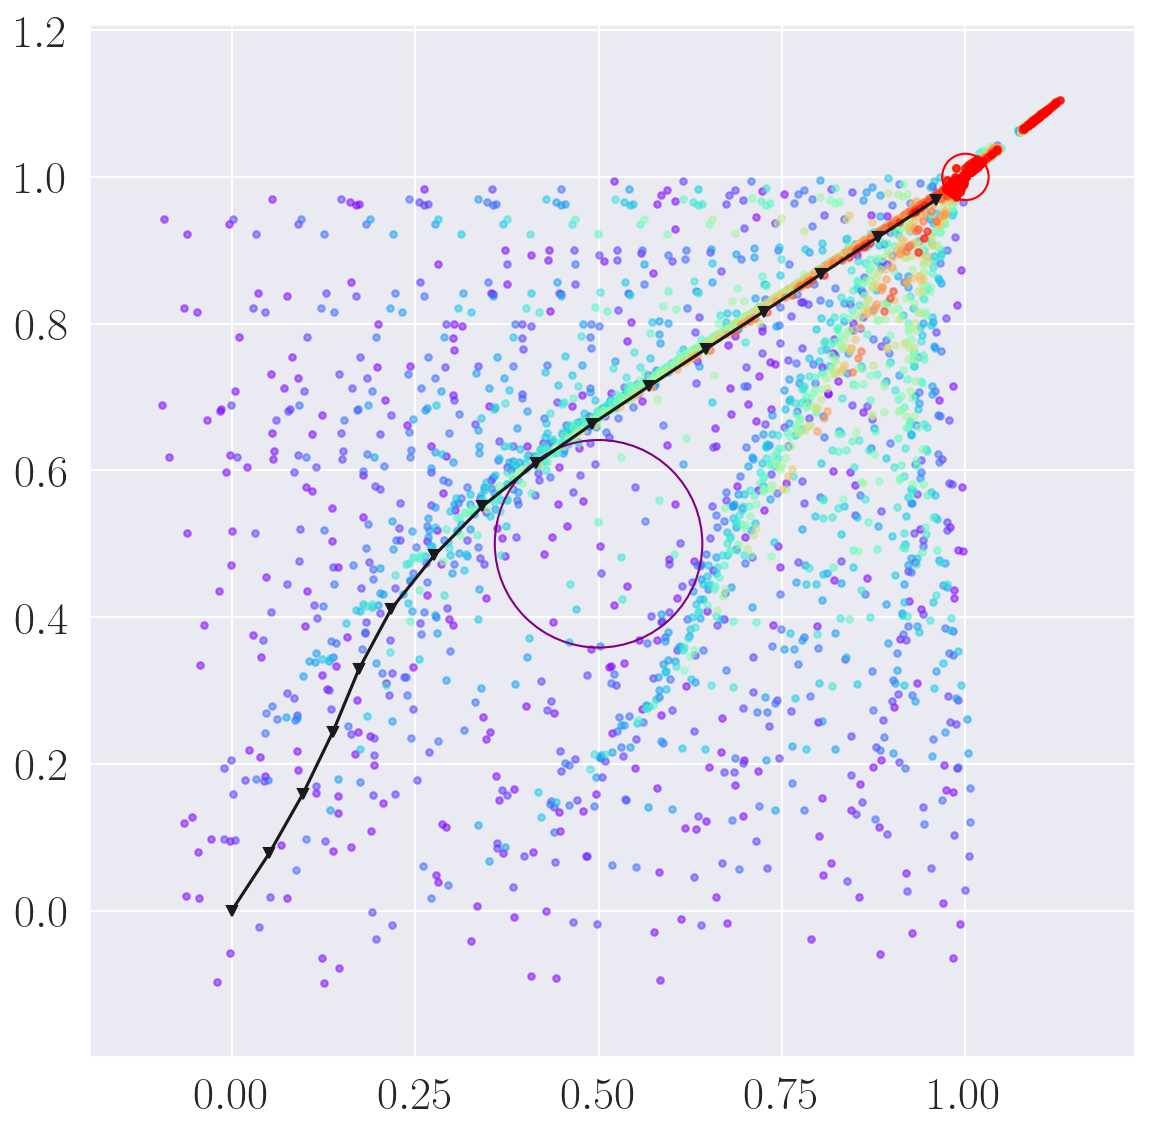

In [36]:
# Create a figure and an axes
color = plt.cm.rainbow(np.linspace(0, 1, N-1))
fig, ax = plt.subplots(1,figsize=(9,9),dpi=150);
for i,c in enumerate(color):
    plt.scatter(f[:,i,0],f[:,i,1],c=c,alpha=0.5,s=10,marker='o');
plt.plot(tx[:,1].squeeze(0),tx[:,2].squeeze(0),c='k',markersize=5,marker='v');
circ = patches.Circle((1,1), radius=np.sqrt(1e-3), linewidth=1, edgecolor='red', facecolor='none')
# circ1 = patches.Circle((.1,.1), radius=torch.sqrt(4./path1.sigma2inv1), linewidth=1, edgecolor='purple', facecolor='none')
circ2 = patches.Circle((.5,.5), radius=torch.sqrt(4./path1.sigma2inv2), linewidth=1, edgecolor='purple', facecolor='none')
# circ3 = patches.Circle((.9,.9), radius=torch.sqrt(4./path1.sigma2inv3), linewidth=1, edgecolor='purple', facecolor='none')
# ax.add_patch(circ1)
ax.add_patch(circ2)
# ax.add_patch(circ3)
ax.add_patch(circ)
plt.xlim(f[:,:,0].squeeze(0).min()-.1, f[:,:,0].squeeze(0).max()+.1);
plt.ylim(f[:,:,1].squeeze(0).min()-.1, f[:,:,1].squeeze(0).max()+.1);
# plt.xticks(np.arange(-1, 1.1, step=0.1));
# plt.yticks(np.arange(-1, 1.1, step=0.1));
ax.set_aspect('equal', adjustable='box');
plt.savefig('test_drive'+version+'.png', bbox_inches='tight');


/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_49012/1440876356.py:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(f[:,anchor+i,0],f[:,anchor+i,1],c=color[i],alpha=0.5,s=10,marker='o');


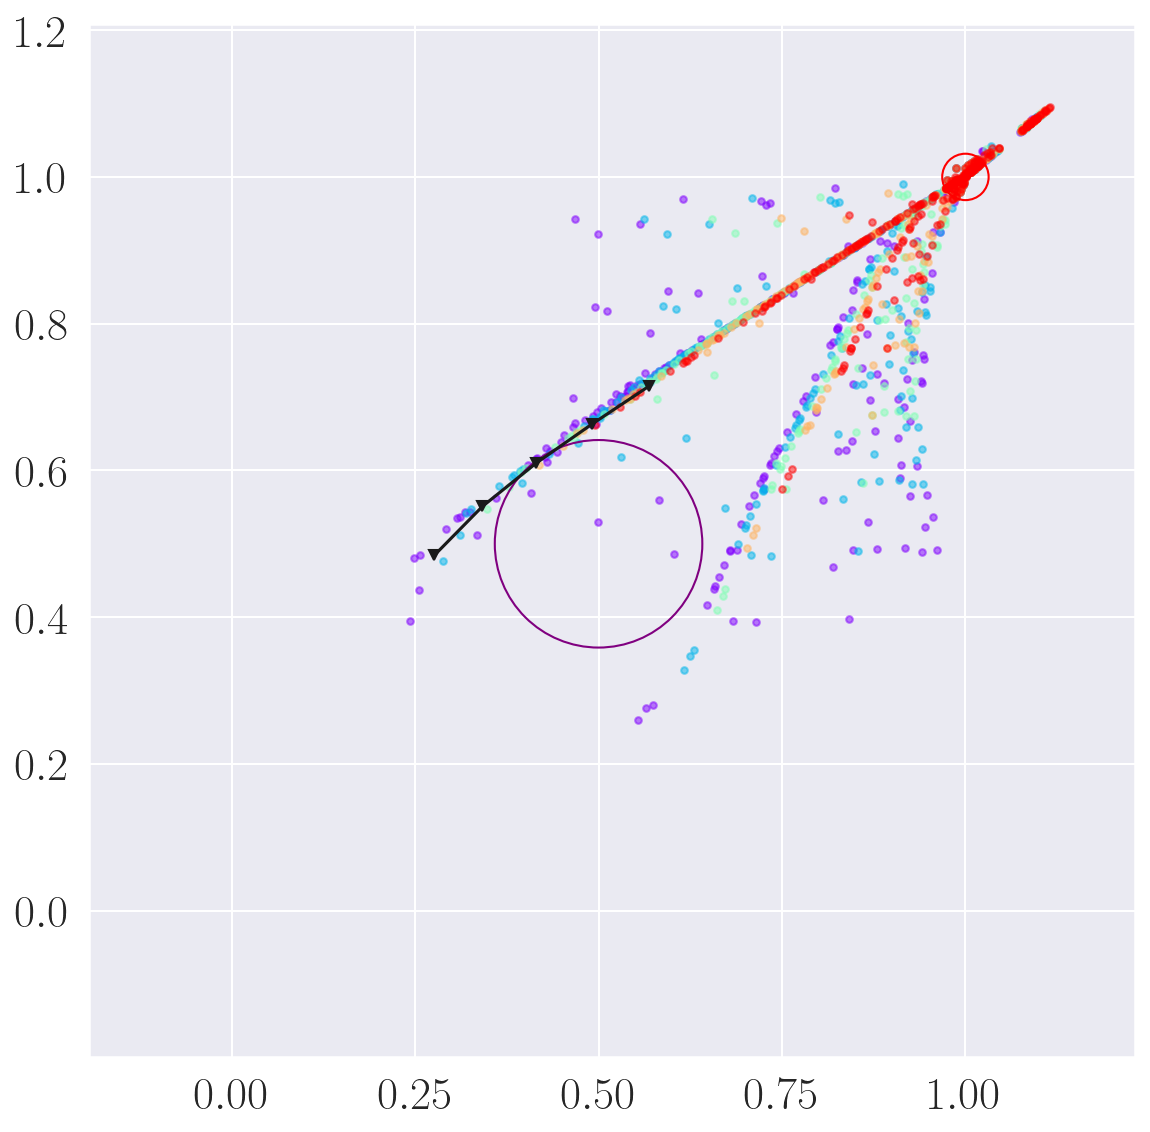

In [66]:
# Create a figure and an axes
M=5
anchor = 6
color = plt.cm.rainbow(np.linspace(0, 1, M))
fig, ax = plt.subplots(1,figsize=(9,9),dpi=150);
for i in range(0,M):
    plt.scatter(f[:,anchor+i,0],f[:,anchor+i,1],c=color[i],alpha=0.5,s=10,marker='o');
plt.plot(tx[anchor:M+anchor,1].squeeze(0),tx[anchor:M+anchor,2].squeeze(0),c='k',markersize=5,marker='v');
circ = patches.Circle((1,1), radius=np.sqrt(1e-3), linewidth=1, edgecolor='red', facecolor='none')
# circ1 = patches.Circle((.1,.1), radius=torch.sqrt(4./path1.sigma2inv1), linewidth=1, edgecolor='purple', facecolor='none')
circ2 = patches.Circle((.5,.5), radius=torch.sqrt(4./path1.sigma2inv2), linewidth=1, edgecolor='purple', facecolor='none')
# circ3 = patches.Circle((.9,.9), radius=torch.sqrt(4./path1.sigma2inv3), linewidth=1, edgecolor='purple', facecolor='none')
# ax.add_patch(circ1)
ax.add_patch(circ2)
# ax.add_patch(circ3)
ax.add_patch(circ)
plt.xlim(f[:,:,0].squeeze(0).min()-.1, f[:,:,0].squeeze(0).max()+.1);
plt.ylim(f[:,:,1].squeeze(0).min()-.1, f[:,:,1].squeeze(0).max()+.1);
# plt.xticks(np.arange(-1, 1.1, step=0.1));
# plt.yticks(np.arange(-1, 1.1, step=0.1));
ax.set_aspect('equal', adjustable='box');
plt.savefig('test_drive'+version+'.png', bbox_inches='tight');


In [68]:
torch.save({
    'tensor': f,
    'metadata': {
        'created': '2023-01-01',
        'description': 'Sample tensor'
    }
}, 'tensor_anim.pt')

In [69]:
import numpy as np
np.save('tensor.npy', f.numpy())

In [92]:
import matplotlib.animation as animation
from IPython.display import HTML
from matplotlib.cm import get_cmap

fig, ax = plt.subplots(1,figsize=(9,9),dpi=150)
N = f.shape[1]

colors = plt.cm.rainbow(np.linspace(0, 1, N))
cmaps = ['viridis', 'plasma', 'cool', 'spring', 'autumn']
# Generate initial data for the scatter plot

x = f[:,0,0]
y = f[:,0,1]
data = np.column_stack([x, y])
# print(f"interval: {interval}")
# Create a scatter plot
scatter = ax.scatter(x, y)
# print(colors)
circ = patches.Circle((1,1), radius=np.sqrt(1e-3), linewidth=1, edgecolor='red', facecolor='none')
# circ1 = patches.Circle((.1,.1), radius=torch.sqrt(4./path1.sigma2inv1), linewidth=1, edgecolor='purple', facecolor='none')
circ2 = patches.Circle((.5,.5), radius=torch.sqrt(4./path1.sigma2inv2), linewidth=1, edgecolor='purple', facecolor='none')
# circ3 = patches.Circle((.9,.9), radius=torch.sqrt(4./path1.sigma2inv3), linewidth=1, edgecolor='purple', facecolor='none')
# ax.add_patch(circ1)
ax.add_patch(circ2)
# ax.add_patch(circ3)
ax.add_patch(circ)

# Function to update the scatter plot in each frame
def update(i):
    # Generate new random data for the scatter plot
    new_x = f[:,i%N,0]
    new_y = f[:,i%N,1]
    new_data = np.column_stack([new_x, new_y])
    
    # Update the positions of the data points
    scatter.set_offsets(new_data)
    scatter.set_alpha(0.5)  # Update transparency
    scatter.set_sizes([10]*new_x.shape[0])  # Update sizes
    scatter.set_facecolors(colors[i%N])

    ax.plot(tx[i,1].squeeze(0),tx[i,2].squeeze(0),c='k',markersize=5,marker='v')
    # Can't directly change marker type after creation
    ax.set_title(f'$t= {path1.T/path1.num_time_steps*i:.2f}$')
    # scatter.set_array(colors[i])  # Updates colors using current colormap
    # scatter.set_cmap(get_cmap(cmaps[i%len(cmaps)]))  # Update colormap
    return scatter,

# Create an animation
ani = animation.FuncAnimation(fig, update, frames = N, interval=1000, blit=True,save_count=N)

# Display in notebook
plt.close()
HTML(ani.to_html5_video())

/var/folders/9f/dlwft6dn7hxg65r7xqyxvk6r0000gn/T/ipykernel_49012/1205007651.py:49: UserWarning: You passed in an explicit save_count=16 which is being ignored in favor of frames=16.
  ani = animation.FuncAnimation(fig, update, frames = N, interval=1000, blit=True,save_count=N)
